# Introduction

## Dataset CIC-DDoS-2019 Description

**CICDDoS2019** contains benign and the most up-to-date common DDoS attacks, which resembles the true real-world data (PCAPs). It also includes the results of the network traffic analysis using CICFlowMeter-V3 with labeled flows based on the time stamp, source, and destination IPs, source and destination ports, protocols and attack (CSV files).

https://www.unb.ca/cic/datasets/ddos-2019.html

## Objectives
This study aims to evaluate and compare the performance of machine learning and deep learning models in **detecting DDoS attacks** using the **CIC-DDoS-2019** dataset, with a focus on addressing **class imbalance** and optimizing **feature selection**.

# Data Preprocessing

In [ ]:
from google.colab import drive
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.utils import to_categorical
from sklearn.feature_selection import RFE
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/sampled_shuffled_data.csv", low_memory=False)

In [ ]:
data = df.copy()
data.columns = data.columns.str.strip()

In [ ]:
data.shape

(5006311, 88)

In [ ]:
data.columns

Index(['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Le

In [ ]:
data.dtypes

,0
Unnamed: 0,int64
Flow ID,object
Source IP,object
Source Port,int64
Destination IP,object
...,...
Idle Max,float64
Idle Min,float64
SimillarHTTP,object
Inbound,int64


### Drop Columns

#### Socket Related Columns

In [ ]:
socket_cols = [
    'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
    'Destination Port', 'Protocol', 'Timestamp', 'SimillarHTTP'
]
data = data.drop(columns=socket_cols)

#### Zero Variance Columns

In [ ]:
zero_var_cols = [
    'Unnamed: 0', 'Fwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count',
    'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
    'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'
]
data = data.drop(columns=zero_var_cols)

### Handling Missing Values

In [ ]:
data.isnull().sum()

,0
Flow Duration,0
Total Fwd Packets,0
Total Backward Packets,0
Total Length of Fwd Packets,0
Total Length of Bwd Packets,0
...,...
Idle Std,0
Idle Max,0
Idle Min,0
Inbound,0


In [ ]:
inf_mask = np.isinf(data.select_dtypes(include=['int64', 'float64']))
inf_counts = inf_mask.sum()
data = data[~inf_mask.any(axis=1)]

### Class Distribution

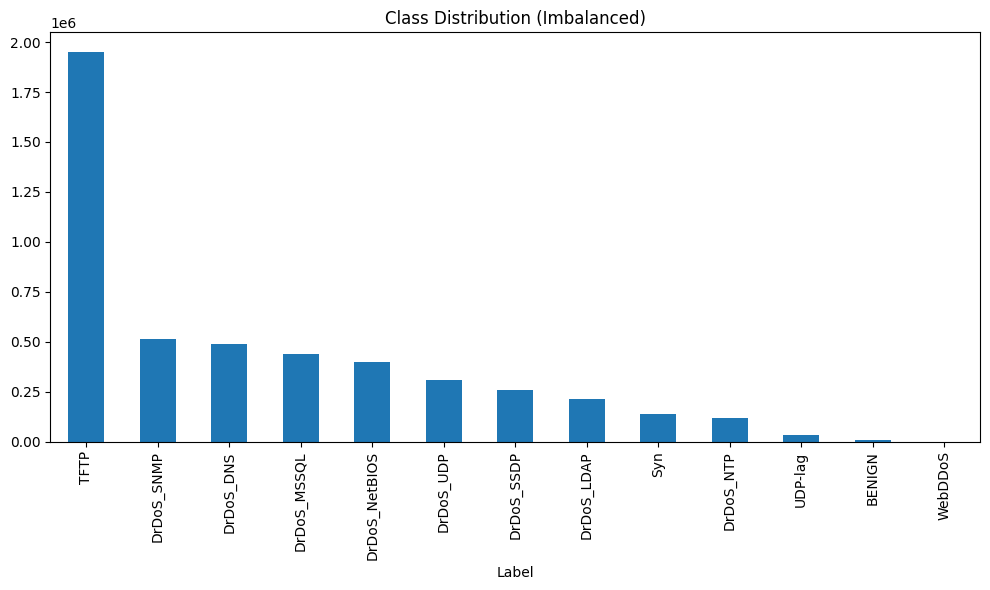

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

data["Label"].value_counts().plot(
    kind='bar',
    ax=ax,
    title='Class Distribution (Imbalanced)'
)

fig.tight_layout()

plt.savefig(
    '/content/drive/My Drive/class_distribution.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

### Split the Dataset with Stratify

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Label']),
    data['Label'],
    test_size=0.2,
    stratify=data['Label'],
    random_state=42
)

### Label Encoding

In [ ]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

num_classes = len(le.classes_)

### Numerical Features Scaling

In [ ]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_cols)

### High Correlation Features Drop

In [ ]:
corr_matrix = pd.DataFrame(X_train_scaled).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

X_train_reduced = pd.DataFrame(X_train_scaled).drop(columns=to_drop)
X_test_reduced = pd.DataFrame(X_test_scaled).drop(columns=to_drop)

# Baseline Model Training

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

results = pd.DataFrame(columns=['model', 'accuracy', 'f1_score', 'precision', 'recall'])

def evaluate_model(y_true, y_pred, title):
    global results
    new_row = {
        'model': title,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred, average='weighted'),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted')
    }
    results.loc[len(results)] = new_row

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

logreg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=200,
    class_weight='balanced',
    C=1.0,
    random_state=42
)
logreg.fit(X_train_reduced, y_train)
y_pred_log = logreg.predict(X_test_reduced)
evaluate_model(y_test, y_pred_log, title="Logistic Regression")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Deep Neural Network

In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_reduced.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_reduced, y_train, epochs=50, batch_size=64,
          validation_split=0.2, callbacks=[early_stop])

y_pred_dnn = model.predict(X_test_reduced)
y_pred_labels = y_pred_dnn.argmax(axis=1)
evaluate_model(y_test, y_pred_labels, title="Deep Neural Network")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
48700/48700 ━━━━━━━━━━━━━━━━━━━━ 177s 4ms/step - accuracy: 0.7892 - loss: 0.5806 - val_accuracy: 0.5204 - val_loss: 1.3323
Epoch 2/50
48700/48700 ━━━━━━━━━━━━━━━━━━━━ 176s 4ms/step - accuracy: 0.8265 - loss: 0.4683 - val_accuracy: 0.8316 - val_loss: 0.4805
Epoch 3/50
48700/48700 ━━━━━━━━━━━━━━━━━━━━ 175s 4ms/step - accuracy: 0.8299 - loss: 0.4571 - val_accuracy: 0.8349 - val_loss: 0.4806
Epoch 4/50
48700/48700 ━━━━━━━━━━━━━━━━━━━━ 172s 4ms/step - accuracy: 0.8306 - loss: 0.4544 - val_accuracy: 0.7950 - val_loss: 0.5530
Epoch 5/50
48700/48700 ━━━━━━━━━━━━━━━━━━━━ 173s 4ms/step - accuracy: 0.8316 - loss: 0.4519 - val_accuracy: 0.7860 - val_loss: 0.6132
Epoch 6/50
48700/48700 ━━━━━━━━━━━━━━━━━━━━ 173s 4ms/step - accuracy: 0.8322 - loss: 0.4487 - val_accuracy: 0.8392 - val_loss: 0.4530
Epoch 7/50
48700/48700 ━━━━━━━━━━━━━━━━━━━━ 175s 4ms/step - accuracy: 0.8329 - loss: 0.4480 - val_accuracy: 0.8348 - val_loss: 0.4724
Epoch 8/50
48700/48700 ━━━━━━━━━━━━━━━━━━━━ 175s 4ms/step - ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    p=2
    )
knn.fit(X_train_reduced, y_train)
y_pred_knn = knn.predict(X_test_reduced)
evaluate_model(y_test, y_pred_knn, title="K-Nearest Neighbors")

### XGBoost

In [ ]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    min_child_weight=1,
    reg_alpha=0.01,
    reg_lambda=1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(X_train_reduced, y_train)

y_pred_xg = model.predict(X_test_reduced)
evaluate_model(y_test, y_pred_xg, title="XGBoost")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train_reduced, y_train)

y_pred_rf = rf_model.predict(X_test_reduced)
evaluate_model(y_test, y_pred_rf, title="Random Forest")

### AdaBoost

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

base_est = DecisionTreeClassifier(max_depth=3)
ab_model = AdaBoostClassifier(estimator=base_est, n_estimators=200, learning_rate=0.5)
ab_model.fit(X_train_reduced, y_train)

y_pred_ab = ab_model.predict(X_test_reduced)
evaluate_model(y_test, y_pred_ab, title="AdaBoost")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### CNN-MLP

In [ ]:
X_train_cnn = X_train_reduced.values.reshape(-1, X_train_reduced.shape[1], 1)
X_valid_cnn = X_test_reduced.values.reshape(-1, X_test_reduced.shape[1], 1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1))
y_valid_ohe = ohe.transform(y_test.reshape(-1, 1))

cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(ohe.categories_[0]), activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_model.fit(X_train_cnn, y_train_ohe, epochs=20, batch_size=64,
              validation_data=(X_valid_cnn, y_valid_ohe),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
              verbose=1)

y_pred_cnn = cnn_model.predict(X_valid_cnn)
y_pred_cnn_labels = y_pred_cnn.argmax(axis=1)
y_true_cnn_labels = y_valid_ohe.argmax(axis=1)
evaluate_model(y_true_cnn_labels, y_pred_cnn_labels, title="CNN-MLP Hybrid")

Epoch 1/20
60875/60875 ━━━━━━━━━━━━━━━━━━━━ 277s 5ms/step - accuracy: 0.8136 - loss: 0.5151 - precision: 0.8491 - recall: 0.7661 - val_accuracy: 0.8408 - val_loss: 0.5526 - val_precision: 0.8545 - val_recall: 0.8232
Epoch 2/20
60875/60875 ━━━━━━━━━━━━━━━━━━━━ 272s 4ms/step - accuracy: 0.8342 - loss: 0.4393 - precision: 0.8528 - recall: 0.8095 - val_accuracy: 0.8363 - val_loss: 0.5066 - val_precision: 0.8527 - val_recall: 0.8111
Epoch 3/20
60875/60875 ━━━━━━━━━━━━━━━━━━━━ 269s 4ms/step - accuracy: 0.8365 - loss: 0.4323 - precision: 0.8532 - recall: 0.8144 - val_accuracy: 0.8404 - val_loss: 0.5326 - val_precision: 0.8531 - val_recall: 0.8265
Epoch 4/20
60875/60875 ━━━━━━━━━━━━━━━━━━━━ 268s 4ms/step - accuracy: 0.8376 - loss: 0.4273 - precision: 0.8535 - recall: 0.8168 - val_accuracy: 0.8348 - val_loss: 0.5899 - val_precision: 0.8598 - val_recall: 0.8105
Epoch 5/20
60875/60875 ━━━━━━━━━━━━━━━━━━━━ 273s 4ms/step - accuracy: 0.8386 - loss: 0.4251 - precision: 0.8538 - recall: 0.8187 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model Evalution

#### Acurracy, F1-Score, Precision & Recall

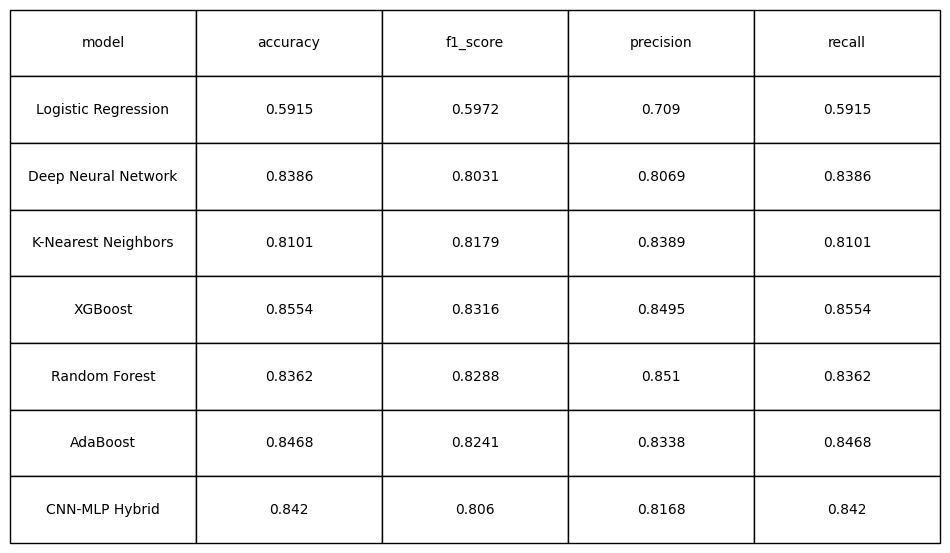

In [ ]:
results = results.round(4)

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')

table = ax.table(cellText=results.values, colLabels=results.columns, cellLoc='center', loc='center')
table.scale(2, 4)

plt.savefig('/content/drive/MyDrive/results_table.png', bbox_inches='tight')

#### Confusion Matrix

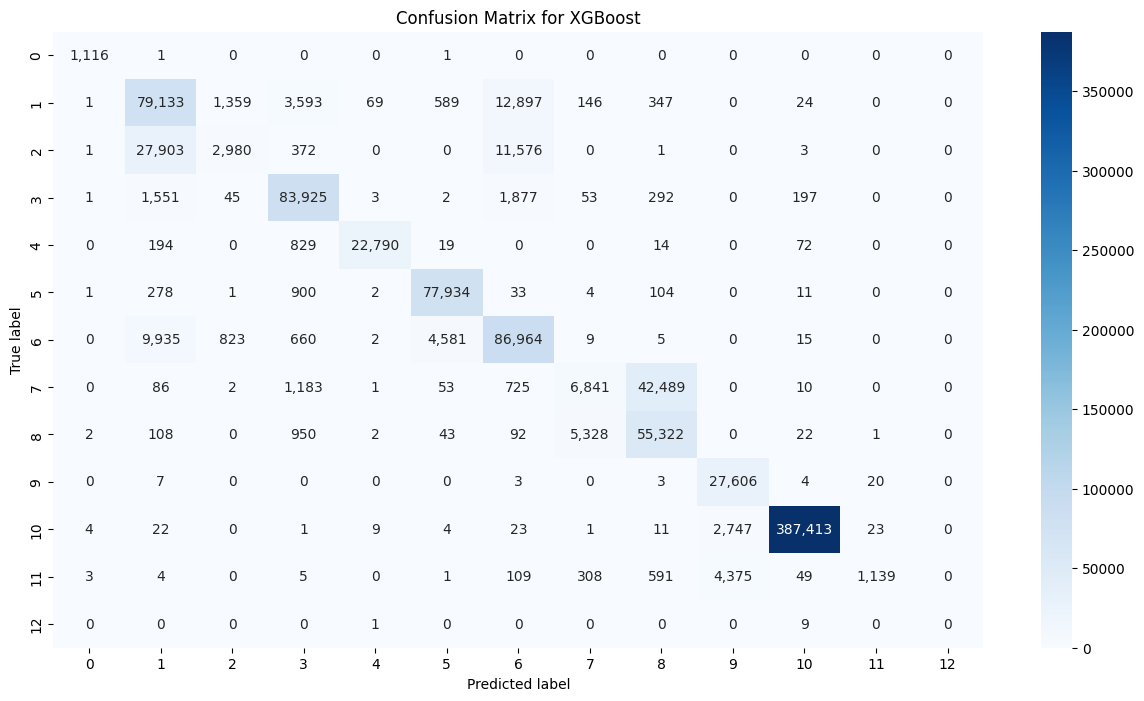

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xg)

plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt=',', cmap='Blues', cbar=True)
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("/content/drive/MyDrive/confusion_matrix_xgb.png", dpi=300, bbox_inches='tight')
plt.show()

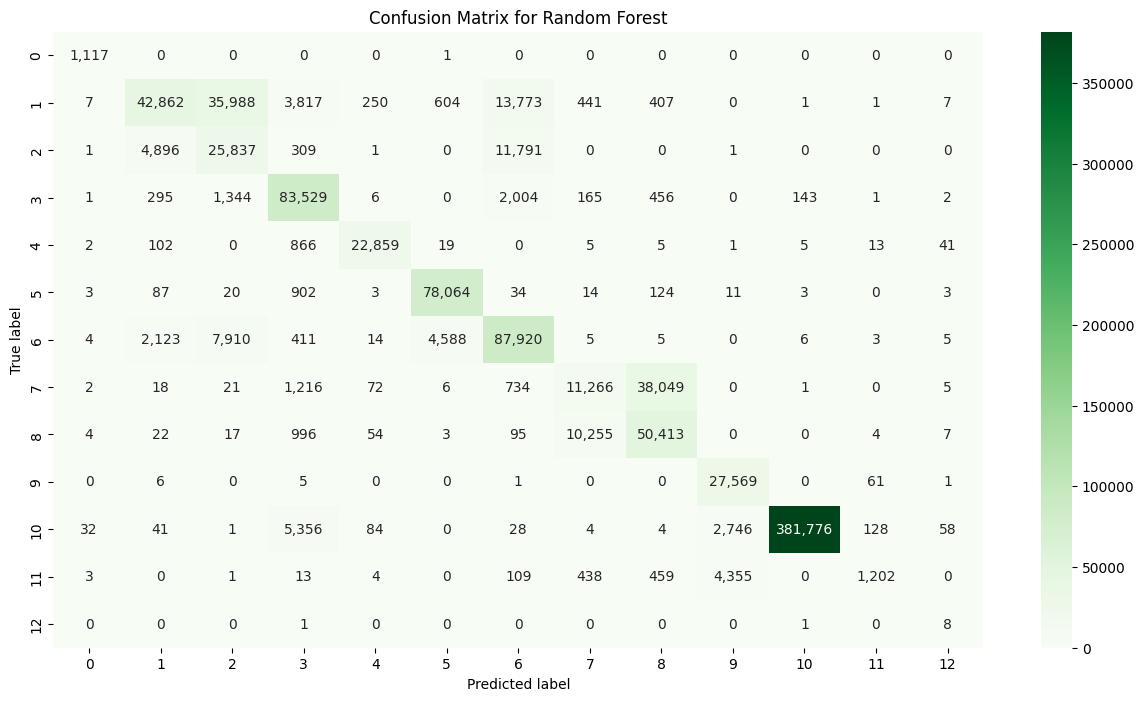

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt=',', cmap='Greens', cbar=True)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("/content/drive/MyDrive/confusion_matrix_rf.png", dpi=300, bbox_inches='tight')
plt.show()

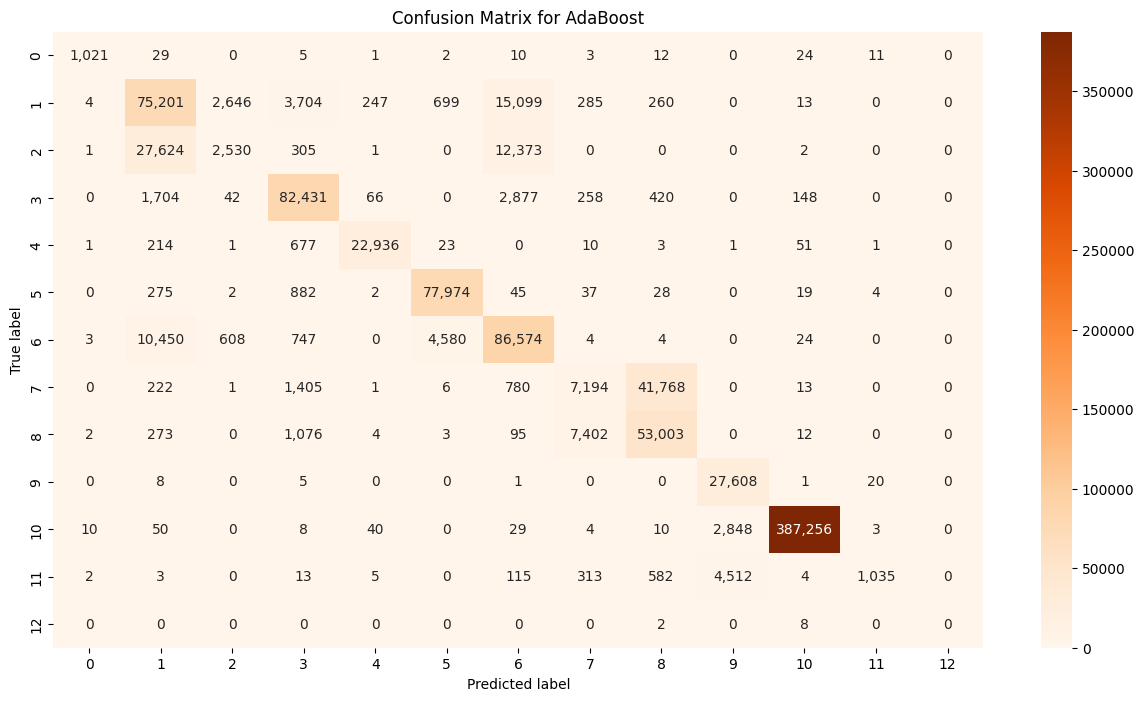

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_ab)

plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt=',', cmap='Oranges', cbar=True)
plt.title("Confusion Matrix for AdaBoost")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("/content/drive/MyDrive/confusion_matrix_adb.png", dpi=300, bbox_inches='tight')
plt.show()

# Random Forest with RFE

### Recursive Feature Elimination

In [ ]:
base_rf = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
rfe_selector = RFE(estimator=base_rf, n_features_to_select=25)
rfe_selector.fit(X_train, y_train)

X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)

### Model Training

In [ ]:
rf_model_rfe = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_model_rfe.fit(X_train_rfe, y_train)
y_pred_rf_rfe = rf_model_rfe.predict(X_test_rfe)

### Model Evaluation

In [ ]:
evaluate_model(y_test, y_pred_rf_rfe, 'Random Forest (RFE)')

#### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf_rfe)
labels = rf_model_rfe.classes_

plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt=',', cmap='Paired', cbar=True)
plt.title("Confusion Matrix for Random Forest (RFE)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("/content/drive/MyDrive/confusion_matrix_rf_rfe.png", dpi=300, bbox_inches='tight')
plt.show()

# XGBoost with SHAP

In [ ]:
corr_matrix = pd.DataFrame(X_train_scaled).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print(f"Highly correlated features to drop ({len(to_drop)}):", to_drop)
X_train_reduced = pd.DataFrame(X_train_scaled).drop(columns=to_drop)
X_test_reduced = pd.DataFrame(X_test_scaled).drop(columns=to_drop)

### SHAP

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(
    X_train_reduced, y_train, test_size=0.2, stratify=y_train, random_state=42
)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train_sub, y_train_sub)

In [ ]:
import shap
import numpy as np
import pandas as pd

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_valid_sub)

if isinstance(shap_values, list):
    shap_values = np.array(shap_values)
    shap_values = np.abs(shap_values)
    shap_array = np.mean(shap_values, axis=0)
else:
    if shap_values.ndim == 3:
        shap_array = np.abs(shap_values).mean(axis=2)
    else:
        shap_array = np.abs(shap_values)

shap_importance = np.mean(shap_array, axis=0)

print(f"shap_importance shape: {shap_importance.shape}")
print(f"Number of features: {len(X_valid_sub.columns)}")

feature_importance_df = pd.DataFrame({
    'feature': X_valid_sub.columns,
    'importance': shap_importance
})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print(feature_importance_df.head(20))

In [ ]:
top_n = 20
selected_features = feature_importance_df['feature'].iloc[:top_n].tolist()

### Model Training

In [ ]:
X_train_shap = X_train_sub[selected_features]
X_valid_shap = X_valid_sub[selected_features]

xgb_shap = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=42
)

xgb_shap.fit(X_train_shap, y_train_sub)

y_pred_shap = xgb_shap.predict(X_valid_shap)

### Model Evaluation

In [ ]:
evaluate_model(y_valid_sub, y_pred_shap, title="XGBoost with SHAP")

#### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_valid_sub, y_pred_shap)

plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt=',', cmap='tab10', cbar=True)
plt.title("Confusion Matrix for XGBoost (SHAP)")
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.savefig("/content/drive/MyDrive/confusion_matrix_xgb_shap.png", dpi=300, bbox_inches='tight')
plt.show()

# AdaBoost with SMOTE and EFS

### SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Ensemble Feature Selection

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_resampled)
rf_imp = rf.feature_importances_

mi_imp = mutual_info_classif(X_train_scaled, y_train_resampled, random_state=42)

all_imps = np.vstack([rf_imp, mi_imp]).T
scaler_efs = MinMaxScaler()
all_imps_norm = scaler_efs.fit_transform(all_imps)

efs_score_fast = all_imps_norm.mean(axis=1)

feature_names = X_train.columns.tolist()
ranked_idx_fast = np.argsort(efs_score_fast)[::-1]
ranked_features_fast = [feature_names[i] for i in ranked_idx_fast]

k = 25
top_k_fast = ranked_features_fast[:k]
print("Fast EFS top features:", top_k_fast)

Fast EFS top features: ['Fwd Packet Length Max', 'Avg Fwd Segment Size', 'Max Packet Length', 'Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Average Packet Size', 'Min Packet Length', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Flow Bytes/s', 'Flow IAT Max', 'Flow IAT Mean', 'Fwd Packets/s', 'Flow Packets/s', 'act_data_pkt_fwd', 'Flow Duration', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Total', 'Flow IAT Std', 'Fwd IAT Std', 'ACK Flag Count', 'Init_Win_bytes_forward', 'Subflow Fwd Packets']


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=feature_names)
X_train_sel = X_train_df[top_k_fast].values
X_test_sel  = X_test_df[top_k_fast].values

In [ ]:
ab = AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42)
ab.fit(X_train_sel, y_train_resampled)
y_pred_ab_efs = ab.predict(X_test_sel)

### Model Evalution

In [ ]:
evaluate_model(y_test, y_pred_ab_efs, title="AdaBoost (EFS) and SMOTE")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,accuracy,f1_score,precision,recall
0,AdaBoost (EFS) and SMOTE,0.523643,0.506368,0.633861,0.523643


#### Confusion Matrix

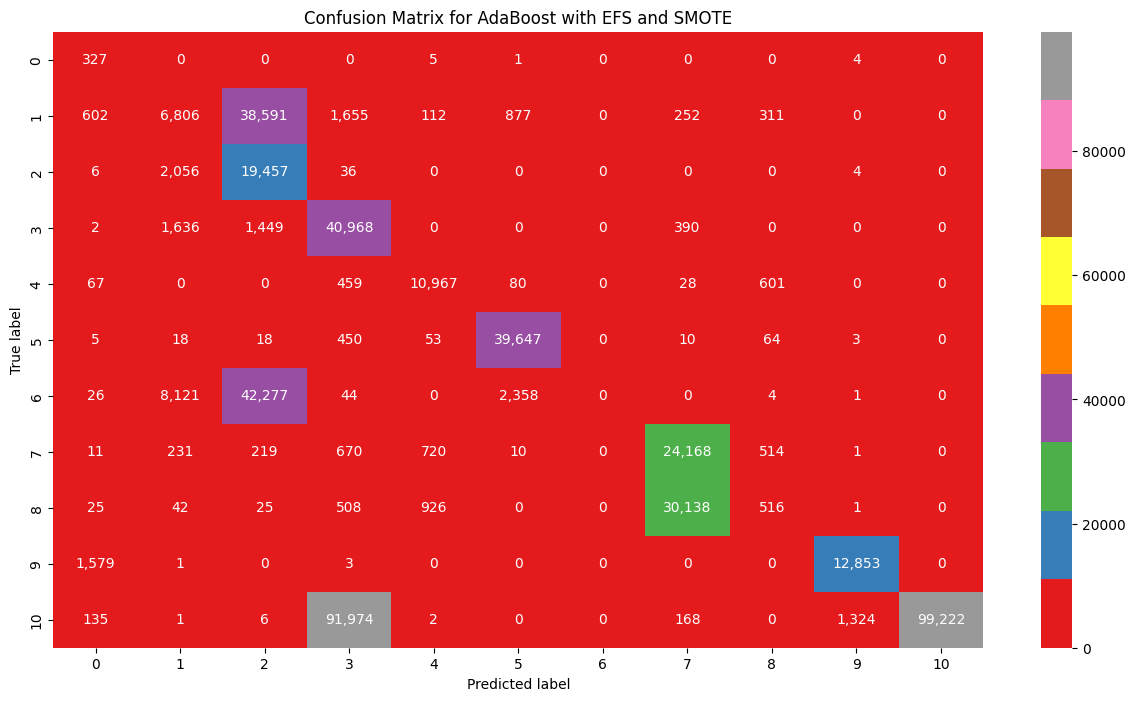

In [ ]:
cm = confusion_matrix(y_test, y_pred_ab_efs)

plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, fmt=',', cmap='Set1', cbar=True)
plt.title("Confusion Matrix for AdaBoost with EFS and SMOTE")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("/content/drive/MyDrive/confusion_matrix_adb_efs_smote.png", dpi=300, bbox_inches='tight')
plt.show()

# Hyperparameters Tuning

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import json


xgb_base = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_sub)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_shap, y_train_sub)

with open("/content/drive/MyDrive/best_xgb_params.json", "w") as f:
    json.dump(random_search.best_params_, f, indent=4)

best_xgb = random_search.best_estimator_

y_pred_best = best_xgb.predict(X_valid_shap)
evaluate_model(y_valid_sub, y_pred_best, title="XGBoost Tuned (SHAP)")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:34:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


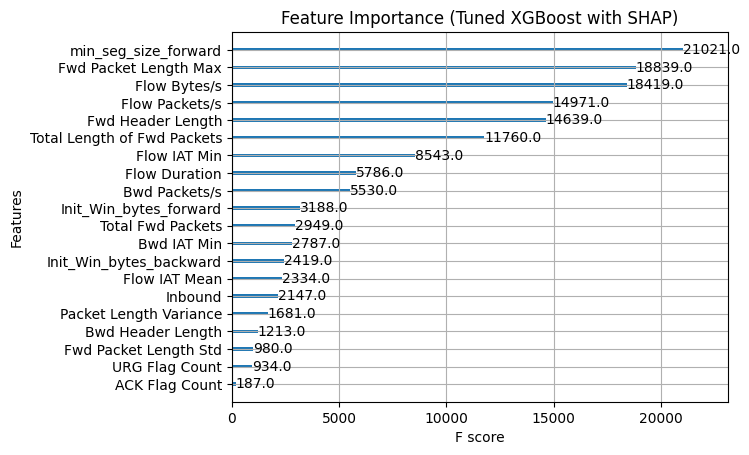

In [ ]:
xgb.plot_importance(best_xgb, max_num_features=20)
plt.title("Feature Importance (Tuned XGBoost with SHAP)")
plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", save_path=None):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='tab10', cbar=True)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

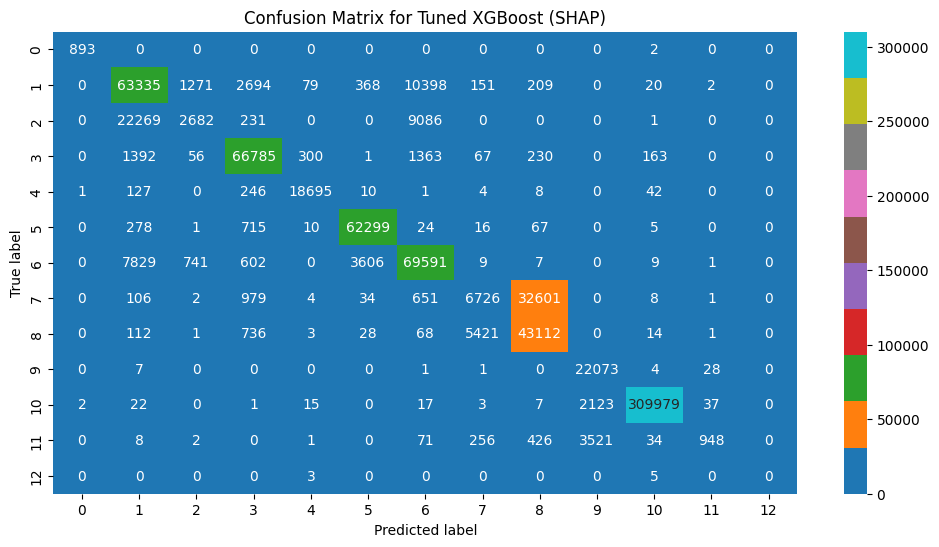

In [ ]:
plot_confusion_matrix(
    y_valid_sub,
    y_pred_best,
    title="Confusion Matrix for Tuned XGBoost (SHAP)",
    save_path="/content/drive/MyDrive/confusion_matrix_xgb_shap_tuned.png"
)